### IMPORT REQUIREMENTS

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta

In [75]:
XAU = pd.read_csv('./XAU_USD Historical Data.csv')
BTC = pd.read_csv('./Bitcoin Historical Data.csv')

In [76]:
print("----- GOLD -------------\n", XAU.head())
print("\n----- BITCOIN ----------\n", BTC.head())

----- GOLD -------------
          Date     Price      Open      High       Low  Vol. Change %
0  12/06/2023  2,028.76  2,018.97  2,035.93  2,018.82   NaN    0.46%
1  12/05/2023  2,019.42  2,030.15  2,041.33  2,010.02   NaN   -0.51%
2  12/04/2023  2,029.74  2,071.25  2,135.90  2,020.34   NaN   -1.99%
3  12/01/2023  2,070.90  2,034.49  2,075.34  2,033.75   NaN    1.73%
4  11/30/2023  2,035.75  2,044.80  2,047.59  2,031.84   NaN   -0.43%

----- BITCOIN ----------
          Date     Price      Open      High       Low     Vol. Change %
0  12/06/2023  43,734.6  44,076.2  44,144.5  43,466.7  101.41K   -0.78%
1  12/05/2023  44,076.2  41,989.6  44,424.1  41,424.9   96.84K    4.97%
2  12/04/2023  41,987.8  39,968.6  42,394.4  39,968.6  104.21K    5.05%
3  12/03/2023  39,970.2  39,456.8  40,178.9  39,280.3   35.27K    1.30%
4  12/02/2023  39,458.4  38,688.2  39,673.4  38,646.5   37.09K    1.99%


### DATA PREPROCESSING

* Data Cleaning

In [77]:
def df_CleanTransform(df):

    # change 'Date' to datetime format & sort by 'Date'
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', inplace=True)

    # change data type to float
    df['High'] = df['High'].str.replace(',', '').astype(float)
    df['Low'] = df['Low'].str.replace(',', '').astype(float)
    df['Open'] = df['Open'].str.replace(',', '').astype(float)
    df['Price'] = df['Price'].str.replace(',', '').astype(float)
    
    df['Change %'] = df['Change %'].str.rstrip('%').astype('float') / 100.0

    df.replace(np.nan, '12345.12345', inplace=True)
    df[df['Vol.'] == '12345.12345']
    df['Volume'] = df['Vol.'].str[:-1].astype(float)
    df['m'] = df['Vol.'].str[-1]
    change_value = {'K': 1000, 'M': 1000000, 'B': 1000000000, '5': 1}
    df['m'] = df['m'].map(change_value)
    df['Vol.'] = df['Volume']*df['m']
    df.replace(12345.1234, np.nan, inplace=True)
    df.drop(['Volume', 'm'], axis=1, inplace=True)

    return df

XAU = df_CleanTransform(XAU)
BTC = df_CleanTransform(BTC)

In [78]:
print("----- nulls in the GOLD dataset -------------\n", XAU.isna().sum())
print("\n----- nulls in the BITCOIN dataset ----------\n", BTC.isna().sum())

----- nulls in the GOLD dataset -------------
 Date           0
Price          0
Open           0
High           0
Low            0
Vol.        3889
Change %       0
dtype: int64
----- nulls in the BITCOIN dataset ----------
 Date        0
Price       0
Open        0
High        0
Low         0
Vol.        6
Change %    0
dtype: int64


In [79]:
XAU.drop('Vol.', axis=1, inplace=True)
BTC.dropna(subset=['Vol.'], inplace=True)

* Technical Feature Extraction

In [80]:
def technical_indicators(df):

    # Rate Of Change
    df['ROC_26'] = ta.momentum.ROCIndicator(close=df['Price'], window=24).roc()
    df['ROC-34'] = ta.momentum.ROCIndicator(close=df['Price'], window=34).roc()
    df['ROC_52'] = ta.momentum.ROCIndicator(close=df['Price'], window=52).roc()
    df['ROC-68'] = ta.momentum.ROCIndicator(close=df['Price'], window=68).roc()    
    df['ROC_78'] = ta.momentum.ROCIndicator(close=df['Price'], window=78).roc()
    df['ROC-102'] = ta.momentum.ROCIndicator(close=df['Price'], window=102).roc()

    # Exponential Moving Average
    df['EMA_14'] = ta.trend.EMAIndicator(close=df['Price'], window=14).ema_indicator() # short-term
    df['EMA_50'] = ta.trend.EMAIndicator(close=df['Price'], window=50).ema_indicator() # mid-term
    df['EMA_120'] = ta.trend.EMAIndicator(close=df['Price'], window=120).ema_indicator() # long-term

    # Relative Strength Index
    df['RSI_28'] = ta.momentum.RSIIndicator(close=df['Price'], window=28).rsi() #mid-term
    df['RSI_28_SMA14'] = ta.trend.SMAIndicator(close=df['RSI_28'], window=14).sma_indicator() # simple moving average of RSI

    # Moving Average Convergence Divergence - LongTerm
    df['MACD_long_macd'] = ta.trend.MACD(close=df['Price'], window_slow=120, window_fast=52, window_sign=20).macd()
    df['MACD_long_diff'] = ta.trend.MACD(close=df['Price'], window_slow=120, window_fast=52, window_sign=20).macd_diff()
    df['MACD_long_signal'] = ta.trend.MACD(close=df['Price'], window_slow=120, window_fast=52, window_sign=20).macd_signal()

    # Moving Average Convergence Divergence - MidTerm
    df['MACD_mid_macd'] = ta.trend.MACD(close=df['Price'], window_slow=52, window_fast=26, window_sign=10).macd()
    df['MACD_mid_diff'] = ta.trend.MACD(close=df['Price'], window_slow=52, window_fast=26, window_sign=10).macd_diff()
    df['MACD_mid_signal'] = ta.trend.MACD(close=df['Price'], window_slow=52, window_fast=26, window_sign=10).macd_signal()

    # Bollinger Bands - LongTerm
    df['BB_50_high'] = ta.volatility.BollingerBands(close=df['Price'], window=50, window_dev=2).bollinger_hband()
    df['BB_50_low'] = ta.volatility.BollingerBands(close=df['Price'], window=50, window_dev=2).bollinger_lband()
    df['BB_50_width'] = ta.volatility.BollingerBands(close=df['Price'], window=50, window_dev=2).bollinger_wband()
    df['BB_50_percentage'] = ta.volatility.BollingerBands(close=df['Price'], window=50, window_dev=2).bollinger_pband()

    # Bollinger Bands - MidTerm
    df['BB_20_high'] = ta.volatility.BollingerBands(close=df['Price'], window=20, window_dev=1.5).bollinger_hband()
    df['BB_20_low'] = ta.volatility.BollingerBands(close=df['Price'], window=20, window_dev=1.5).bollinger_lband()
    df['BB_20_width'] = ta.volatility.BollingerBands(close=df['Price'], window=20, window_dev=1.5).bollinger_wband()
    df['BB_20_percentage'] = ta.volatility.BollingerBands(close=df['Price'], window=20, window_dev=1.5).bollinger_pband()

    # Ichimoku Cloud
    df['IchiCloud_SpanA'] = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], visual=True).ichimoku_a()
    df['IchiCloud_SpanB'] = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], visual=True).ichimoku_b()
    df['IchiCloud_KijunSen'] = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], visual=True).ichimoku_base_line()
    df['IchiCloud_TenkanSen'] = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], visual=True).ichimoku_conversion_line()

    return df

XAU = technical_indicators(XAU)
BTC = technical_indicators(BTC)

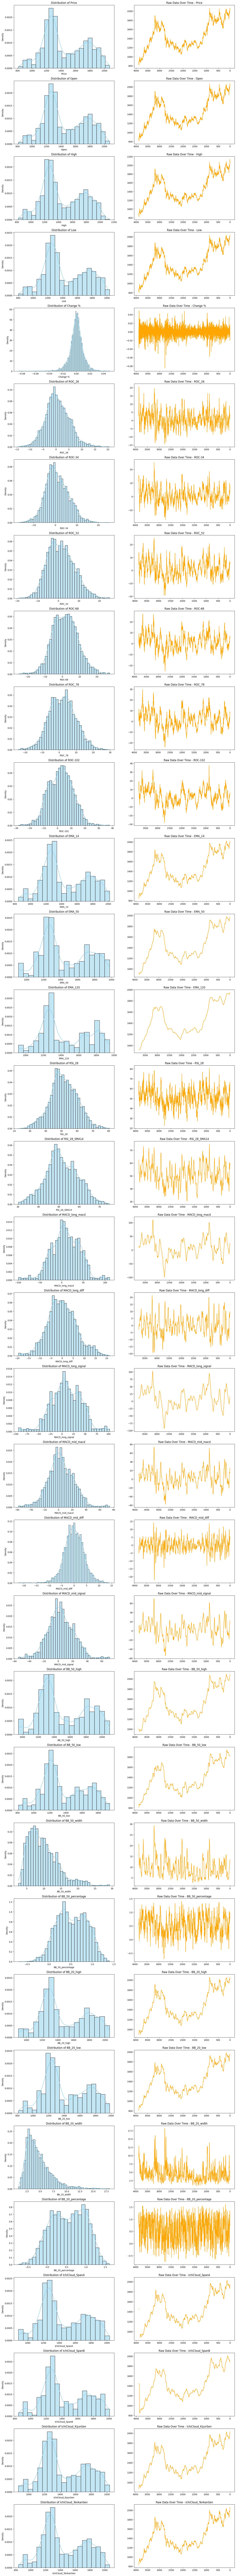

In [101]:
fig, axes = plt.subplots(nrows=len(XAU.columns[1:]), ncols=2, figsize=(18, 6 * len(XAU.columns)))

for i, column in enumerate(XAU.columns[1:]):
    # Distribution plot
    sns.histplot(XAU[column], kde=True, ax=axes[i, 0], color='skyblue', stat='density')
    axes[i, 0].set_title(f'Distribution of {column}')

    # Raw data over time
    XAU[column].plot(ax=axes[i, 1], color='orange')
    axes[i, 1].set_title(f'Raw Data Over Time - {column}')
    axes[i, 1].invert_xaxis()